<h1 style="font-size: 36px; color: #FFD700">3 - Neural Networks</h1>

Neural networks có thể xây dựng bằng cách sử dụng torch.nn

nn: Định nghĩa các lớp mạng (models), vd: nn.Linear, nn.Conv2d, ...

autograd: Tự động tính gradient, xây dựng compulational graph tự động trong lúc thực thi

=> Mối quan hệ: nn định nghĩa kiến trúc mô hình, autograd xử lý quá trình Backward, tính đạo hàm và lưu dúng cho việc cập nhật.

    => nn phụ thuộc autograd để có thể trainable

Một nn.Module sẽ chứa các lớp kiến trúc và một phương thức forward(input) trả về output

Ví dụ:

<img src="https://pytorch.org/tutorials/_images/mnist.png" alt="Ảnh online" style="background-color:white; padding:10px;">

Giải thích từng thuật ngữ & Vai trò cụ thể:
- `Input` - ảnh đưa vào mạng, ở đây là ảnh xám kích thức 32x32 (vd chữ viết tay)
- `Convolution layer` (C1, C3) - Lớp tích chập 
    - Tác vụ: 
        - Trích xuất đặc trưng(feature) từ ảnh hoặc feature maps trước đó 
        - Mỗi filter (kernel) học cách nhận biết các đặc điểm như cạnh, góc, nét cong,...
        - Tạo ra feature maps – là biểu diễn không gian các đặc trưng tìm được
    Trong LeNet:
        - C1: Có 6 filters → 6 feature maps 28x28
        - C3: Có 16 filters → 16 feature maps 10x10
- `Subsampling/ Pooling` - Lớp gộp/ giảm mẫu
    - Tác vụ:
        - Giảm kích thước không gian của feature maps (ví dụ từ 28x28 → 14x14)
        - Giúp mạng học nhanh hơn và giảm overfitting
        - MaxPooling thường được dùng: chọn giá trị lớn nhất trong mỗi vùng nhỏ
    - Trong LeNet:
        - S2: 6 feature maps 14x14
        - S4: 16 feature maps 5x5
- `Fully Connected Layers` - Lớp kết nối đầy đủ:
    - Tác vụ:
        - Kết nối toàn bộ các giá trị đặc trưng trước đó với tất cả các neurons tiếp theo
        - Thực hiện tổng hợp thông tin toàn cục để chuẩn bị phân loại
        - Giống như "não" của mạng quyết định ảnh thuộc lớp nào
    - Trong LeNet:
        - F5: 120 neurons
        - F6: 84 neurons
- `Output layer` (10 neural) - Lớp output đầu ra:
    - Tác vụ: 
        - Mỗi neuron tương ứng với một lớp phân loại (ví dụ 0 đến 9 nếu là nhận diện chữ số)
        - Sau khi áp dụng Softmax, cho ra xác suất cho từng lớp
        - Lớp nào có xác suất cao nhất → là kết quả dự đoán
 - `Feature Maps` - Bản đồ đặc trưng
    - Tác vụ:
        - Là kết quả của mỗi filter khi quét qua ảnh hoặc feature map trước đó
        - Cho biết tại vị trí nào trong ảnh đang có đặc trưng cần tìm
- `Gaussian connections` - Kết nối Gaussian
    - Tác vụ: Trong LeNet gốc, không phải neuron nào trong lớp fully connected cũng kết nối với tất cả đầu vào. Chỉ kết nối theo mẫu “Gaussian” để tiết kiệm tài nguyên thời đó
    - Ngày nay, ta thường dùng full connection thay vì kiểu kết nối này


In [1]:
import torch
import torch.nn as nn 
import torch.nn.functional as F

In [2]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__() # 1 input channel, 6 ouput channel, nhân tích chập vuông 5x5
        self.conv1 = nn.Conv2d(1, 6, 5)
        self.conv2 = nn.Conv2d(6, 16, 5)
        # Một phép toán biến đổi: y = Wx + b
        self.fc1 = nn.Linear(16*5*5, 120) # 5*5 là chiều ảnh 5 pixel weight, 5 pixel height
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
        
    def forward(self, input):
        # Lớp C1: 1 image input channel, 6 output channel
        # Conv 5x5 sử dụng hàm kích hoạt ReLU
        # Tensor output có size(N, 6, 28, 28), N là batch size
        c1 = F.relu(self.conv1(input))
        
        # Lớp S2: Lấy mẫu có grid là 2x2, đây hoàn toàn là hàm chức năng
        # Lớp này không có bất kỳ tham số nào, output tensor size(N, 6, 14, 14)
        s2 = F.max_pool2d(c1, (2, 2))
        
        # Lớp C3: 6 input channel, 16 output channels
        # 5x5 conv, dùng hàm kích hoạt ReLU 
        # Tensor output (N, 16, 10, 10)
        c3 = F.relu(self.conv2(s2))
        
        # Lớp S4: Tương tự S2, tensor output (N, 16, 5, 5)
        s4 = F.max_pool2d(c3, 2)
        
        # flatten: hàm thuần chức năng, chuyển matrix -> vector 
        # output tensor: (N, 400)
        s4 = torch.flatten(s4, 1)
        
        # Lớp F5:tensor input (N, 400), tensor output (N, 120), sdung hàm ReLU
        f5 = F.relu(self.fc1(s4))
        
        # Lớp F6: tensor input (N, 120), tensor output (N, 84), sdung hàm ReLu
        f6 = F.relu(self.fc2(f5))
        
        # Lớp gaussian output: (N, 84) Tensor input, and tensor output(N, 10)
        output = self.fc3(f6)
        return output

`max_pool` - làm giảm kích thước của dữ liệu đầu vào trong khi giữ lại các đặc trưng quan trọng. Giúp `giảm chi phí` và giảm `overfitting`

Cách hoạt động:
- Chia dữ liệu thành các cửa sổ nhỏ (windows): Mỗi cửa sổ là một khu vực con của dữ liệu đầu vào, ví dụ, một vùng 2x2 hoặc 3x3 của ảnh
- Chọn giá trị lớn nhất trong mỗi cửa sổ: MaxPooling chọn giá trị lớn nhất trong mỗi cửa sổ và giữ lại nó, trong khi loại bỏ các giá trị còn lại
- Lặp lại quá trình trên toàn bộ dữ liệu đầu vào: Điều này sẽ giúp giảm kích thước của dữ liệu (ví dụ, giảm chiều rộng và chiều cao của ảnh)

In [3]:
net = Net()
print(net)

Net(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)


Ta cần định nghĩa hàm forward, backward - nơi tính gradient sẽ tự động được định nghĩa bằng autograd. Ta có thể sdung bất kỳ phép toán Tensor nào trong hàm forward

Các tham số có thể được học của model đc trả về bởi net.parameters()

In [4]:
params = list(net.parameters())
print(len(params))
print(params[0].size()) #conv1 weight

10
torch.Size([6, 1, 5, 5])


Lưu ý: kích thước đầu vào dự kiến ​​của lưới này (LeNet) là 32x32. Để sử dụng lưới này trên tập dữ liệu MNIST, ta phải thay đổi kích thước hình ảnh từ tập dữ liệu thành 32x32.

In [5]:
input = torch.randn(1, 1, 32, 32)
out = net(input)
print(out)

tensor([[ 0.0231, -0.0121, -0.1361, -0.1448, -0.1607, -0.0162,  0.0655, -0.0951,
         -0.1019, -0.0271]], grad_fn=<AddmmBackward0>)


Đặt các tham số và backprop về 0 và thực hiện gradient ngẫu nhiên:
- Mục đích đặt lại để các tham số không bị cộng dồn qua mỗi lần gọi hàm backward().

In [6]:
net.zero_grad() # đặt lại gradient bằng 0
out.backward(torch.randn(1, 10))

- vì output không phải scalar nên khi thực hiện backward phải điền vào một một tensor ngẫu nhiên có shape giống với output (giá trị đc lấy mẫu từ pp chuẩn Gaussian với tb=0 và đlc=1) nó có tác dụng tính gradient lần đầu tiên trước trong quá trình backward.

Ghi chú:
- torch.nn được thiết kế để xử lý dữ liệu theo batch
- nếu ta chỉ có 1 sample, sử dụng input.unsqueeze(0) để kích hoạt batch fake

In [7]:
# input = torch.rand(3, 224, 224)  # 1 ảnh RGB
# batch_input = input.unsqueeze(0)  # Thêm chiều batch -> [1, 3, 224, 224]
# output = model(batch_input)       # Chạy được!

- số 0 đối số của `unsqueeze()` là vị trí của dim mới thêm vào batch. 
- unsqueeze(dim)

    - dim=0: Thêm chiều batch ở đầu (ví dụ: [C, H, W] → [1, C, H, W]).

    - dim=1: Thêm chiều ở vị trí thứ 1 (ví dụ: [C, H, W] → [C, 1, H, W]).

    - dim=-1: Thêm chiều ở cuối (ví dụ: [C, H, W] → [C, H, W, 1]).

`torch.Tensor` - Một mảng đa chiều trong PyTorch, hỗ trợ tính toán tự động (autograd) như phép `backward()`. Nó cũng lưu giữ gradient (độ dốc) liên quan đến tensor.

`nn.Module` - Lớp cơ sở để xây dựng các mô-đun mạng nơ-ron. Cung cấp cách thuận tiện để đóng gói các tham số, với các tiện ích để chuyển chúng lên GPU, lưu/tải mô hình, v.v.

`nn.Parameter` - Một loại Tensor đặc biệt, tự động được đăng ký là tham số của `Module` khi được gán làm thuộc tính của một `Module`.

`autograd.Function` - Định nghĩa các phép toán tự động (forward/backward). Mỗi phép toán trên Tensor tạo ra ít nhất một nút Function, kết nối với các hàm đã tạo ra Tensor đó và ghi lại lịch sử tính toán.

`LOSS FUNCTION`

`Loss function` lấy cặp (output, target) và tính toán giá trị ước tính từ khoảng cách từ output đến target

In [8]:
output = net(input)
target = torch.randn(10)
target = target.view(1, -1) # giống reshape

criterion = nn.MSELoss()

loss = criterion(output, target)
print(loss)

tensor(0.8947, grad_fn=<MseLossBackward0>)


Giải thích tham số (1, -1)
- 1: Đặt kích thước chiều đầu tiên (batch size) = 1
→ Tạo 1 batch duy nhất chứa mẫu dữ liệu.

- -1: PyTorch tự động tính toán chiều này dựa trên tổng số phần tử tensor.
→ Công thức: `-1 = total_elements / other_dims`

Nếu ta theo loss hướng ngược lại, sử dụng thuộc tính `.grad_fn` của nó, ta sẽ thấy biểu đồ tính toán trông như sau:

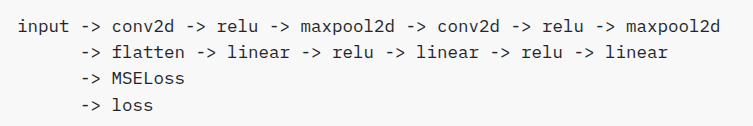

Khi gọi `loss.backward()`, PyTorch sẽ tự động tính toán gradient (đạo hàm) cho tất cả các tham số trong mạng nơ-ron (các Tensor có `requires_grad=True`) và lưu giá trị gradient vào thuộc tính `.grad` của chúng.

In [9]:
print(loss.grad_fn)  # MSELoss
print(loss.grad_fn.next_functions[0][0])  # Linear
print(loss.grad_fn.next_functions[0][0].next_functions[0][0])  # ReLU

`.next_functions` sẽ giúp ta đến các lớp (bước) trước trong đồ thị tính toán `computational graph`

=> loss.grad_fn sẽ đưa ta đến node cuối cùng (`backward function`) trước output. Khi ta gọi `.next_functions` nó sẽ đưa ta về bước trước đó là linear và tiếp tục là relu và nữa thì là linear

`BACKPROP` 

`Backprop` - thuật toán lan truyền ngược để cập nhật các trọng số (weights) trong mạng neural trong khi train.

Để `lan truyền ngược` thì ta chỉ cần sử dụng `loss.backward()`. 
- `Note`: ta phải xóa các `gradient` hiện có nếu không gradient sẽ đuợc tích lũy vào gradient hiện có.

In [11]:
# Ta xét một vd gradient của conv1 trước/ sau khi backward
net.zero_grad() # Xóa các gradient

print('conv1.bias.grad before backward')
print(net.conv1.bias.grad)

loss.backward() # Hàm sẽ tính các gradient của tham số dựa trên loss_func

print('conv1.bias.grad after backward')
print(net.conv1.bias.grad)

conv1.bias.grad before backward
None
conv1.bias.grad after backward
tensor([-0.0022, -0.0037,  0.0091, -0.0083,  0.0075, -0.0028])


`Giải thích chi tiết từng bước thực hiện`:

`Trước khi gọi backward` - Vì ta chưa tính gradient => `net.conv1.bias.grad` là None (Do Pytorch không tự động tính gradient trừ khi ta yêu cầu qua `backward()`)
- `net.zero_grad()`: được gọi để reset các giá trị gradient => trành cộng dồn các gradient (cũ + mới)

`Khi gọi backward` - Pytorch sẽ tính gradient của loss với tất cả các tham số của models (weight, bias của tất cả các lớn). Quá trình này đi ngược từ loss về các lớp trước đó trong mạng và tính toán gradient cho mỗi tham số theo `chain-rule`
- gradient sẽ được lưu vào các `thuộc tính grad` của các tham số tương ứng với models
- Sau khi `backward()` được ta sẽ nhìn thấy các giá trị gradient trong `conv1.bias.grad` - nơi chứa gradient bias của lớp conv1 (muốn coi lớp nào thì gọi lớp đó)

`Sau khi gọi backward` - sau khi `loss.backward()` đuợc gọi thì các gradient cho các tham số của lớp conv1 sẽ được sẽ được tính toán và lưu trong conv1.bias.grad
- Khi ta gọi để hiển thị thì ta nhận được giá trị thực tế của gradient

`UPDATE WEIGHTS` - Quy tắc cập nhật đơn giản nhất được sử dụng trong thực tế là SGD (`Stochastic Gradient Descent`)

`weight = weight - learning_rate * gradient`

In [12]:
learning_rate = 0.01
for f in net.parameters():
    f.data.sub_(f.grad.data * learning_rate)

`GIẢI THÍCH`

`learning_rate = 0.01` - quyết định mức độ thay đổi của các tham số trong mỗi bước huấn luyện,`lr = 0.01` có nghĩa mỗi lần cập nhật trọng số thì gradient sẽ nhân với lr để điều chỉnh trọng số một cách chậm hơn

`for f in net.parameters():` 
- net.parameters() trả về tất cả các tham số của mô hình trong mạng `net`
- `f` là từng tham số trọng mạng

=> Duyệt qua từng tham số trong mô hình để thực hiện việc `update weight`

`f.data.sub_(f.grad.data * learning_rate)` - là nơi thực hiện việc `update weight`
- `f.data`: đây là giá trị thực tế của tham số f. `.data` là một cách để truy cập giá trị thực của tensor mà không yêu cầu tính toán gradient 
- `f.grad.data`: đây là gradient của tham số f. Gradient cho biết mức độ thay đổi cần thiết của tham số f để giảm thiểu loss. Gradient này đã được tính toán khi gọi loss.backward()
- `.sub_()`: sẽ trừ đi giá trị của biểu thức bên phải từ giá trị hiện tại của f.data vì sub_() là phương thức in_place, nó sẽ cập nhật giá trị của f.data ngay lập tức

*`in-place` - là phương thức mà khi ta thao tác trực tiếp trên dữ liệu đầu vào mà `không cần thêm bộ nhớ phụ đáng kể`. Thay vì tạo ra bản sao của dữ liệu mới thì nó `thay đổi trực tiếp dữ liệu gốc`

Khi ta tối ưu mạng neural thì không chỉ có cách `update weight` đơn giản như trên mà là các quy tắc cập nhật khác nhau: `SGD`, `Nesterov-SGD`, `Adam`, `RMSProp`, ...

=> Pytorch có package để triển khai các phương pháp này.

In [ ]:
import torch.optim as optim

optimizer = optim.SGD(net.parameters(), lr=0.01)

optimizer.zero_grad() 
output = net(input)
loss = criterion(output, target)
loss.backward()
optimizer.step() 

`GIẢI THÍCH`

`optimizer = optim.SGD(net.parameters(), lr=0.01)`
- `optimizer`: là một đối tượng tối ưu hóa, được sử dụng để cập nhật trọng số của mô hình trong quá trình train
- `optim.SGD`: là cách để tạo ra Stochastic Gradient Descent optimizer
- `net.parameters()`: Đây là các tham số  của mô hình
    - `net`: Bạn cung cấp các tham số này cho optimizer để optimizer có thể cập nhật chúng trong quá trình train
    - `lr=0.01`: Đây là learning rate (tỷ lệ học), quyết định mức độ thay đổi của các tham số trong mỗi lần cập nhật

`optimizer.zero_grad()` - Vì pytorch không tự động được xóa giữa các lần cập nhật

=> ta phải gọi `.zero_grad()` để đặt lại các gradient trước khi tính toán mới => tránh cộng dồn 

`output = net(input)` - buớc forward để đưa ra một dự đoán từ net

`loss = criterion(output, target)` - tính toán hàm loss giữa đầu ra mô hình và giá trị thực tế. Hàm này đo lường sự sai lechj giữa output và target

`loss.backward()` - gọi phương thức này để tính toán các gradient của các tham số trong mô hình đối với loss. Sau khi gọi `loss.backward()' thì các gradient sẽ được tính toán tự động thông qua quá trình lan truyền ngược và lưu vào .grad của các tham số trong mô hình.

`optimizer.step()` - sau các bước tính toán thì ta gọi để  `update weight` cho models. Optimizer sẽ dùng các gradient và lr đã cho để thực hiện việc cập nhật các tham số sao cho giảm thiểu loss